## INTRODUCTION: - 
When growing a successful business, one of the most crucial elements is the communication and the relationships you have with your customers. However, one of the main challenges with a growing user base is the large amount of data generated, often in the form of natural language. This data can be driven from customer feedback or even on social media platforms where customers express their thoughts and opinion towards their experiences using your service or products.


The real challenge is to automatically parse and organise this data into a more digestible and actionable insight. One of the most popular natural language processing techniques to apply on such data is Sentiment Analysis. Sentiment Analysis aims to automatically extract and classify sentiments (the subjective part of an opinion) and/or emotions (the projections or display of a feeling) expressed in text.


An opinion may be defined as a combination of four factors (entity, holder, claim, and sentiment), in which the opinion holder may believe a claim about an entity, and in many cases, associate a sentiment with that belief. As opposed to extracting the general sentiment expressed in a piece of text, Aspect-Based Sentiment Analysis aims to extract both the entity described in the text (in this case, attributes or components of a product or service) and the sentiment expressed towards such entities.


The advantages gained from exploring how your customers are reacting towards particular parts of your service or product can help support business use cases, including product development and quality control, communications, customer support, and decision making processes. In this case, this post investigates combining traditional topic modelling techniques with sentiment analysis to extract text aspects, as well as the sentiment expressed towards them.

#### Import all important libarires

In [1]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gzip

## Read the data

#### About the data:- 
The dataset used  is taken by Julian McAuley. It contains product reviews and metadata from Amazon, including 142.8 million reviews spanning between May 1996 — July 2014. This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs). Here, we’ll use reviews for cell phones and accessories. The total number of reviews in this dataset is 194,439.

In [2]:
data = pd.read_json("C:/Users/anjal/Desktop/Cell_Phones_and_Accessories_5.json",lines=True)

In [3]:
data.head()  ##first 5 rows of the data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [4]:
data.info()  ##information 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      194439 non-null  object
 1   asin            194439 non-null  object
 2   reviewerName    190920 non-null  object
 3   helpful         194439 non-null  object
 4   reviewText      194439 non-null  object
 5   overall         194439 non-null  int64 
 6   summary         194439 non-null  object
 7   unixReviewTime  194439 non-null  int64 
 8   reviewTime      194439 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.4+ MB


Extract only reviewstext column from the datasets to analyse the products reviews

In [5]:
df=data[['reviewText']]

In [6]:
df

,reviewText
0,They look good and stick good! I just don't li...
1,These stickers work like the review says they ...
2,These are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use..."
...,...
194434,Works great just like my original one. I reall...
194435,Great product. Great packaging. High quality a...
194436,"This is a great cable, just as good as the mor..."
194437,I really like it becasue it works well with my...


## Data Preprocessing

To run the text data smoothly we have to do datapreprocessing it's the most important task in aspect based opinion mining.

In the below code we remove all the puntuations,extra whitespace and convert the whole text into lowercase.

In [7]:
##case text as lower ,remove puntuation,remove extra whitespace in string and both side of string
df['remove_lower_punct'] = df['reviewText'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()
display(df.head(5))

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,remove_lower_punct
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...
1,These stickers work like the review says they ...,these stickers work like the review says they ...
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...


Various techniques and methodologies have been developed to address automatically identifying the sentiment expressed in the text. Here, I’ll use VADER, a Python sentiment analysis library, to classify whether the reviews are positive, negative, or neutral.

A very simple approach to sentiment analysis is by using a list of words which have been labelled according to their semantic orientation. For example, we can assume that the word “good” has a positive valence, whereas the word “bad” has a negative one. VADER uses this technique and provides a percentage score which represents the proportion of lyrics which fall in each sentiment category. It also provides a compound score which is computed by summing the valence scores of each word and then normalising the scores to be between -1 (most extreme negative) and +1 (most extreme positive).

First, we’ll import the "SentimentIntensityAnalyzer" function from VADER’s Python library. I’ll initialise the sentiment analyser from VADER, and then iterate over the reviews from the dataframe. I’ll then calculate whether the compound sentiment score is above or beneath the thresholds so that we can assign them with the positive, negative, or neutral label.

In [8]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,reviewText,remove_lower_punct,sentiment,sentiment score
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Positive,0.4922
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572


In the below code we will tokenize the reviews text.Tokenization is the important step in text analytics. The process of breaking down a text paragraph into smaller chunks such as words or sentence is called Tokenization. Token is a single entity that is building blocks for sentence or paragraph.

In [9]:
# tokenise string

df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

display(df.head(10))

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Positive,0.4922,"[they, look, good, and, stick, good, i, just, ..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo..."
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ..."
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ..."
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ..."
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ..."


Now we will remove the stopwords from the review text.Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc.

In NLTK for removing stopwords, you need to create a list of stopwords and filter out your list of tokens from these words.
As in the code we have used english stopwords from the nltk librbary and we have also created our personal stopword list and extended the list of stop words.

In [10]:
# initiate stopwords from nltk

stop_words = stopwords.words('english')

# add additional missing terms

stop_words.extend(stop_words_list)

In [11]:
# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
display(df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Positive,0.4922,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]"
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]"
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]"
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea..."


Now we will lemmmatise the word to their word root.Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis. Lemmatization is usually more sophisticated than stemming.

In [13]:
# initiate nltk lemmatiser

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

C:\Users\anjal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
display(df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Positive,0.4922,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]","[button, easy, daughter, purchase, worth, price]"
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]","[described, unstuck, cute, people, driving]"
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]","[worked, week, charge, phone, waste, money]"
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go...","[good, case, solid, build, protects, phone, go..."
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea...","[fantastic, case, stylish, protects, phone, ea..."


In the Text Classification Problem, we have a set of texts and their respective labels. But we directly can't use text for our model. You need to convert these text into some numbers or vectors of numbers.

Bag-of-words model(BoW ) is the simplest way of extracting features from the text. BoW converts text into the matrix of occurrence of words within a document. This model concerns about whether given words occurred or not in the document.

In the below  code we have used bag of word technique to convert our text into some matrix.We have countvectorizer in the code to convert our text to matrix.

In [15]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

In [45]:
print(vectorised)

  (0, 723168)	1
  (0, 1631906)	1
  (0, 722755)	1
  (0, 1446046)	1
  (0, 1509740)	1
  (0, 210768)	1
  (0, 1539762)	1
  (0, 1262593)	1
  (0, 884560)	1
  (0, 218683)	1
  (1, 1633449)	1
  (1, 1895513)	1
  (1, 1429993)	1
  (1, 1632496)	1
  (1, 1627410)	1
  (1, 1218556)	1
  (1, 1667247)	1
  (1, 1656357)	1
  (1, 1511030)	1
  (2, 103160)	1
  (2, 1218480)	1
  (2, 1656493)	1
  (2, 1917605)	1
  (2, 1916904)	1
  (3, 889176)	1
  :	:
  (194437, 1315151)	1
  (194437, 250693)	1
  (194437, 952053)	1
  (194437, 133773)	1
  (194438, 1894784)	1
  (194438, 282091)	1
  (194438, 1892389)	1
  (194438, 1250038)	1
  (194438, 1306221)	1
  (194438, 987867)	1
  (194438, 1439441)	1
  (194438, 888620)	1
  (194438, 939917)	1
  (194438, 1217919)	1
  (194438, 1778965)	1
  (194438, 381579)	1
  (194438, 382346)	1
  (194438, 1540299)	1
  (194438, 1212422)	1
  (194438, 485376)	1
  (194438, 382410)	1
  (194438, 1856973)	1
  (194438, 1063474)	1
  (194438, 218859)	1
  (194438, 451862)	1


## Topic Modelling

Topic modelling is an unsupervised machine learning approach used to distribute texts into groups which best characterise such documents. This concept can also be used to extract text aspects.

Sklearn includes a version of the Latent Dirichlet Allocation (LDA) algorithm. For this concept, we want to extract five aspects. Once the parameters are set, we can fit the LDA to the vectorised version of the text.

In [16]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

To make the output easier to read, we can append the relevance score produced for each topic to each review as a column and calculate the dominant topic by taking the topic with the highest relevance score.

In [17]:
# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

In [18]:
# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

In [19]:

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,reviewText,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Dominant_topic
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,Positive,0.4922,"[they, look, good, and, stick, good, i, just, ...","[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s...",0.93,0.02,0.02,0.02,0.02,1
1,These stickers work like the review says they ...,these stickers work like the review says they ...,Positive,0.9136,"[these, stickers, work, like, the, review, say...","[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su...",0.02,0.02,0.92,0.02,0.02,3
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,Positive,0.8481,"[these, are, awesome, and, make, my, phone, lo...","[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]",0.60,0.03,0.03,0.03,0.30,1
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,Positive,0.9584,"[item, arrived, in, great, time, and, was, in,...","[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde...",0.01,0.95,0.01,0.01,0.01,2
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,Positive,0.8957,"[awesome, stays, on, and, looks, great, can, b...","[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail...",0.02,0.02,0.02,0.02,0.91,5
5,These make using the home button easy. My daug...,these make using the home button easy my daugh...,Positive,0.8126,"[these, make, using, the, home, button, easy, ...","[button, easy, daughter, purchase, worth, price]","[button, easy, daughter, purchase, worth, price]",0.03,0.03,0.03,0.03,0.87,5
6,Came just as described.. It doesn't come unstu...,came just as described it doesnt come unstuck ...,Positive,0.7964,"[came, just, as, described, it, doesnt, come, ...","[described, unstuck, cute, people, driving]","[described, unstuck, cute, people, driving]",0.84,0.04,0.04,0.04,0.04,1
7,it worked for the first week then it only char...,it worked for the first week then it only char...,Negative,-0.4215,"[it, worked, for, the, first, week, then, it, ...","[worked, week, charge, phone, waste, money]","[worked, week, charge, phone, waste, money]",0.86,0.03,0.03,0.03,0.03,1
8,"Good case, solid build. Protects phone all aro...",good case solid build protects phone all aroun...,Positive,0.8555,"[good, case, solid, build, protects, phone, al...","[good, case, solid, build, protects, phone, go...","[good, case, solid, build, protects, phone, go...",0.01,0.01,0.01,0.01,0.96,5
9,This is a fantastic case. Very stylish and pro...,this is a fantastic case very stylish and prot...,Positive,0.9572,"[this, is, a, fantastic, case, very, stylish, ...","[fantastic, case, stylish, protects, phone, ea...","[fantastic, case, stylish, protects, phone, ea...",0.01,0.01,0.43,0.01,0.53,5


Now we can see which topic (by its number) a review belongs to. But what keywords, in this case text aspects, has the LDA extracted from such reviews? We can view them by calling the vectoriser’s "get_feature_names()" and see their relevance score to that aspect using the LDA’s "components_"functions:

In [20]:
# index names
docnames = ['Doc' + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

In [21]:
df_document_topic

,Topic1,Topic2,Topic3,Topic4,Topic5
Doc0,0.93,0.02,0.02,0.02,0.02
Doc1,0.02,0.02,0.92,0.02,0.02
Doc2,0.60,0.03,0.03,0.03,0.30
Doc3,0.01,0.95,0.01,0.01,0.01
Doc4,0.02,0.02,0.02,0.02,0.91
...,...,...,...,...,...
Doc194434,0.03,0.03,0.47,0.03,0.43
Doc194435,0.01,0.01,0.71,0.01,0.26
Doc194436,0.00,0.00,0.52,0.47,0.00
Doc194437,0.02,0.02,0.02,0.02,0.91


In [22]:

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [23]:
dominant_topic

array([0, 2, 0, ..., 2, 4, 3], dtype=int64)

In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
df_topic_keywords

,0,1,2,3,4,5,6,7,8,9,...,1922776,1922777,1922778,1922779,1922780,1922781,1922782,1922783,1922784,1922785
0,0.200000,0.2,0.200000,0.200001,0.2,1.196742,0.2,1.198983,1.199997,1.200302,...,1.197906,1.2,0.200001,0.200000,3.199010,1.198802,0.200000,0.200002,0.200002,0.200002
1,0.200000,1.2,1.197879,0.200001,0.2,0.200001,1.2,0.200000,0.200001,0.200005,...,0.200001,0.2,0.200001,1.199998,0.200000,0.200000,0.200000,0.200002,0.200001,0.200002
2,0.200000,0.2,0.202120,0.203425,0.2,0.203256,0.2,0.200000,0.200001,0.200005,...,0.202091,0.2,1.199998,0.200000,0.200989,0.201198,1.199999,1.199993,1.199994,1.199991
3,0.200000,0.2,0.200000,0.200001,0.2,0.200001,0.2,0.201017,0.200001,1.199683,...,0.200001,0.2,0.200001,0.200000,0.200000,0.200000,0.200000,0.200002,0.200002,0.200002
4,1.199999,0.2,0.200000,1.196573,1.2,0.200001,0.2,0.200000,0.200001,0.200005,...,0.200001,0.2,0.200001,0.200000,0.200000,0.200000,0.200000,0.200002,0.200001,0.200002


In [25]:
 ##Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names


In [26]:
df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

In [27]:
df_topic_no

,0
01 update,Topic5
02 day,Topic2
02 update,Topic2
03 day,Topic5
04 update,Topic5
...,...
zz reduces,Topic1
zzz sleep,Topic3
zzzap refund,Topic3
zzzs rate,Topic3


In [28]:
df_scores

,0
01 update,1.199999
02 day,1.200000
02 update,1.197879
03 day,1.196573
04 update,1.200000
...,...
zz reduces,1.198802
zzz sleep,1.199999
zzzap refund,1.199993
zzzs rate,1.199994


In [29]:
tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

In [30]:
display(tmp)

,topic,relevance_score
01 update,Topic5,1.199999
02 day,Topic2,1.200000
02 update,Topic2,1.197879
03 day,Topic5,1.196573
04 update,Topic5,1.200000
...,...,...
zz reduces,Topic1,1.198802
zzz sleep,Topic3,1.199999
zzzap refund,Topic3,1.199993
zzzs rate,Topic3,1.199994


We determine which aspect a keyword belongs to by taking its highest relevance score across the five aspects. Then, for each aspect, we can order our dataframe in descending order and select the keywords with the highest score

In [31]:
##We determine which aspect a keyword belongs to by taking its highest relevance score across the five aspects. 
##Then, for each aspect, we can order our dataframe in descending order and select the keywords with the highest score

all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] 
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)



In [32]:
all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)  ##Top 5 dominant topic 

,Dominant_topic,topic_name
0,Topic5,[phone case]
1,Topic2,[screen protector]
2,Topic1,[galaxy note]
3,Topic4,[battery life]
4,Topic3,[usb port]


In [33]:
replace_dict = {"Topic1":1,"Topic2":2,"Topic3":3, "Topic4":4, "Topic5":5}  ##replace the dominant topic keywords to number
all_topics["Dominant_topic"] = all_topics["Dominant_topic"].replace(replace_dict)
all_topics

,Dominant_topic,topic_name
0,5,[phone case]
1,2,[screen protector]
2,1,[galaxy note]
3,4,[battery life]
4,3,[usb port]


In [34]:
##groupby the domninant topic and sentiment with count funtion and reset the index
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()  
results

,Dominant_topic,sentiment,reviewText,remove_lower_punct,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5
0,1,Negative,4250,4250,4250,4250,4250,4250,4250,4250,4250,4250,4250
1,1,Neutral,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252
2,1,Positive,27318,27318,27318,27318,27318,27318,27318,27318,27318,27318,27318
3,2,Negative,4610,4610,4610,4610,4610,4610,4610,4610,4610,4610,4610
4,2,Neutral,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140
5,2,Positive,29868,29868,29868,29868,29868,29868,29868,29868,29868,29868,29868
6,3,Negative,5595,5595,5595,5595,5595,5595,5595,5595,5595,5595,5595
7,3,Neutral,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583,1583
8,3,Positive,35720,35720,35720,35720,35720,35720,35720,35720,35720,35720,35720
9,4,Negative,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073,4073


In [35]:
##merged all topics with results variable on the basis of dominant topic
results = results.merge(all_topics, how = 'left', on='Dominant_topic') 

results.head(3)

,Dominant_topic,sentiment,reviewText,remove_lower_punct,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,topic_name
0,1,Negative,4250,4250,4250,4250,4250,4250,4250,4250,4250,4250,4250,[galaxy note]
1,1,Neutral,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252,[galaxy note]
2,1,Positive,27318,27318,27318,27318,27318,27318,27318,27318,27318,27318,27318,[galaxy note]


In [36]:
results['topic_name'] = results['topic_name'].apply(', '.join)

In [37]:
graph_results = results[['topic_name', 'sentiment', 'sentiment score']]

In the below code we determine the sentiment of the particular aspects which we have extract from the review.It show's which aspects has most positive reviews and which has negative review and which aspect has neutral review.  

In [38]:
##make the pivot table with aspects(topic_name) extractes from the reviews with there sentiments score 
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()
graph_results.set_index('topic_name', inplace=True)

display(graph_results)  

sentiment,Negative,Neutral,Positive
topic_name,,,
battery life,4073,941,24689
galaxy note,4250,1252,27318
phone case,5392,1312,46696
screen protector,4610,1140,29868
usb port,5595,1583,35720


Once we’ve retrieved the compound scores for each review, we can plot and count the number of positive, negative, and neutral reviews for each of the five aspects.

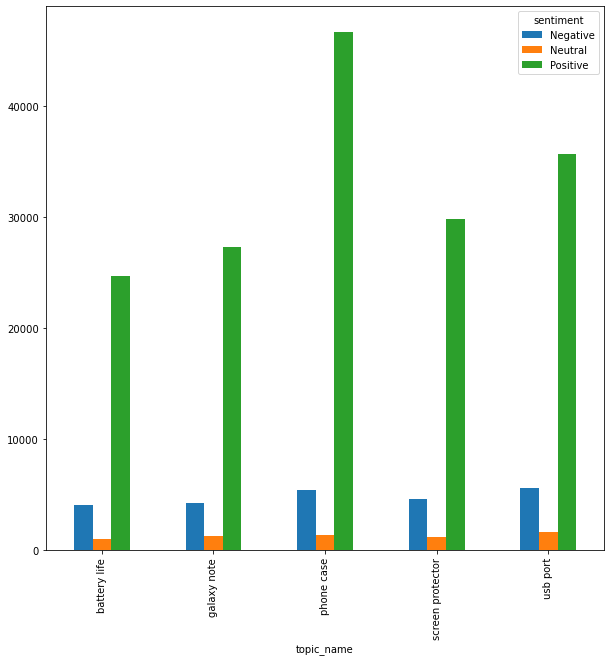

In [39]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')

This chart reports that the majority of the reviews for each aspect are positive. In particular, with more than 80,00 reviews, the screen "phone case" received 49,572 positive ones. For a business, having more than 50% of your reviews expressing a positive sentiment is a good indication that your customers are satisfied with the product.

What other potential insights can we gather? Let’s dive deeper into what the customers are saying. For this concept, we’ll use the reviews for the phone case.

One of the main features used to support Sentiment Analysis include individual sentiment words (e.g. good, bad) which explicitly convey a subjective bias. Sentiment words are available from specialised dictionaries, where they have been mapped to their sentiment.

These words are often adjectives (e.g. good, bad), adverbs (e.g. cheerfully, weirdly), nouns (e.g. blessing, rubbish), and verbs (e.g. love, hate). Sentiment may also be expressed by using comparative words (e.g. better, worse). To identify those adjectives, adverbs, nouns, and verbs in text, we can apply Part of Speech (POS) tagging. POS tagging is the process of marking up a word in a text as corresponding to a particular part of speech (noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, or determiner), based on both its definition and its context.

Here, we use the NLTK POS tagger to identify the POS tags. As we’ve got quite a large dataset, we want to automatically narrow down the sentiment words as much as possible. In this case, we’re able to identify English and correctly spelt words and map them to SentiWordNet, a lexical resource for opinion mining. SentiWordNet assigns words three sentiment scores: positivity, negativity, and objectivity.

In [40]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anjal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

To capture sentiment words from subjective ones, we use WordNet-Affect, another lexical resource which represents affective concepts correlated with affective words in a hierarchical structure. Once we’ve checked whether the subjective words are in WordNet-Affect, we can be quite confident that these are sentiment words. Based on their SentiWordNet positive and negative score, we can also split them up into separate collections and count how many times they appear across the whole dataset.

In [41]:
from nltk.corpus import wordnet
from tqdm import tqdm
import nltk
nltk.download('sentiwordnet')
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in tqdm(df['Dominant_topic'].unique()):
    if i == 1:
        tmp_1 = df.loc[df['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                negative_words.append(p[0])      
                    except:
                        pass

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\anjal\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:19<00:00, 87.98s/it]


In [42]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

We’ll illustrate the results in a word cloud, a simple visualisation of data in which words are shown in varying sizes depending on how often they appear in your data. The size of a word shows how often it appears in a review.

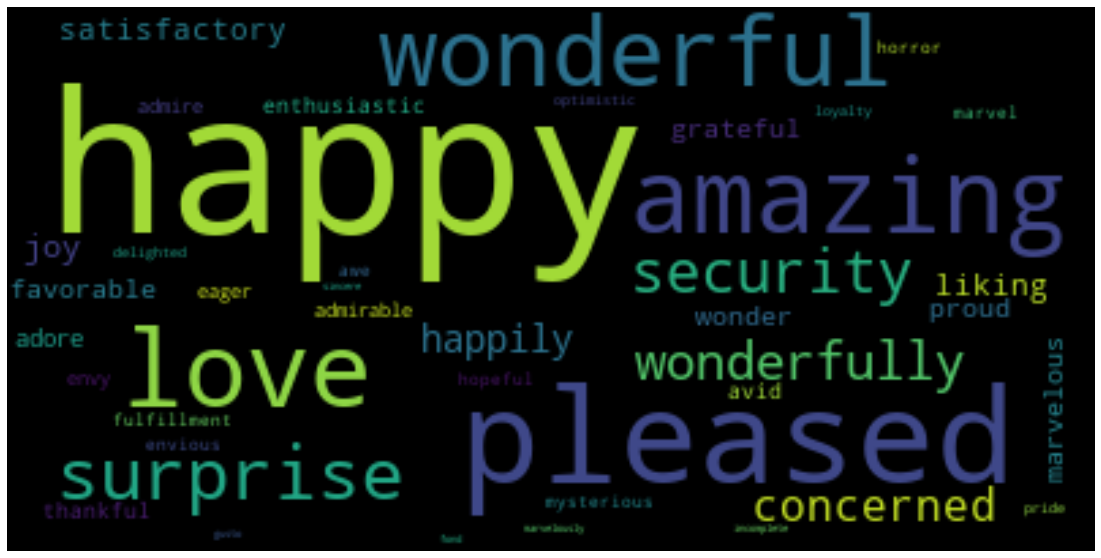

In [43]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('positive_words.png')
plt.show()

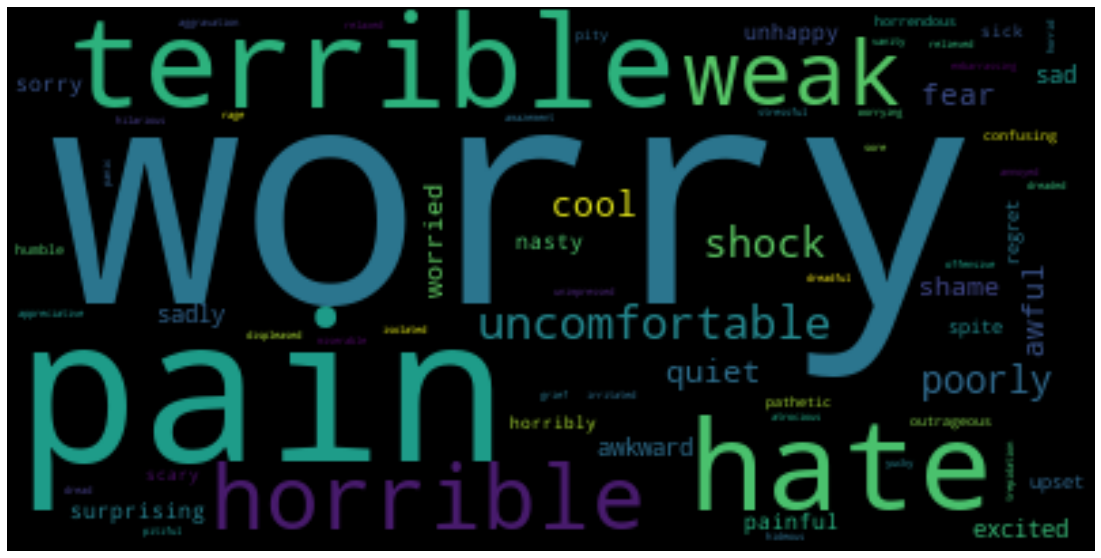

In [44]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('negative_words.png')
plt.show()

Based on both word clouds, it’s quite clear that the most common positive and negative sentiment words used in the reviews are happy and worry respectively. For a business, again, having happy as the most popular positive sentiment word is reassuring